In [10]:
import osmnx as ox
import networkx as nx
import pandas as pd
import warnings
import time
from concurrent.futures import ThreadPoolExecutor

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print(f"Using OSMnx version: {ox.__version__}")

# List of cities to analyze
cities = [
    "Amsterdam, Netherlands",
    "Boston, USA",
    "Barcelona, Spain"
]

# Function to compute street network metrics
def compute_street_metrics(city_name):
    print(f"📍 Processing: {city_name}...")

    try:
        start_time = time.time()

        # Load street network
        G = ox.graph_from_place(city_name, network_type="drive")

        if G is None or len(G) == 0:
            print(f"❌ Error: No valid graph for {city_name}")
            return None

        print(f"✅ Data loaded for {city_name} in {time.time() - start_time:.2f} sec.")

        # Convert to undirected graph
        G_undirected = G.to_undirected()

        # Compute basic statistics
        stats = ox.stats.basic_stats(G_undirected)

        if not stats:
            print(f"❌ Error: No stats available for {city_name}")
            return None

        # Get convex hull area (in km²)
        area_km2 = ox.geocode_to_gdf(city_name).geometry.iloc[0].convex_hull.area / 10**6

        # Compute intersection and street density manually
        intersection_density = stats["intersection_count"] / area_km2 if area_km2 > 0 else "Missing"
        street_density = stats["street_length_total"] / area_km2 if area_km2 > 0 else "Missing"

        # Store final results
        result = {
            "city": city_name,
            "intersection_density": round(intersection_density, 3) if isinstance(intersection_density, (int, float)) else "Missing",
            "street_density": round(street_density, 3) if isinstance(street_density, (int, float)) else "Missing",
            "circuity": round(stats.get("circuity_avg", "Missing"), 6),
        }

        print(f"✅ Finished processing {city_name} in {time.time() - start_time:.2f} sec.")
        return result

    except Exception as e:
        print(f"❌ Error processing {city_name}: {e}")
        return None

# Process cities in parallel
with ThreadPoolExecutor() as executor:
    city_metrics = list(executor.map(compute_street_metrics, cities))

# Filter out None results
city_metrics = [entry for entry in city_metrics if entry]

# Convert to DataFrame and save results
df = pd.DataFrame(city_metrics)

if df.empty:
    print("\n⚠️ No valid data collected. Check for OSMnx version or connectivity issues.")
else:
    df.to_csv("city_street_metrics.csv", index=False)
    print("\n📊 Comparison of city street network metrics:")
    print(df)


Using OSMnx version: 2.0.1
📍 Processing: Amsterdam, Netherlands...
📍 Processing: Boston, USA...
📍 Processing: Barcelona, Spain...
✅ Data loaded for Barcelona, Spain in 82.98 sec.
✅ Finished processing Barcelona, Spain in 87.30 sec.
✅ Data loaded for Boston, USA in 102.83 sec.
✅ Data loaded for Amsterdam, Netherlands in 104.50 sec.
✅ Finished processing Boston, USA in 111.92 sec.
✅ Finished processing Amsterdam, Netherlands in 112.90 sec.

📊 Comparison of city street network metrics:
                     city  intersection_density  street_density  circuity
0  Amsterdam, Netherlands          3.005436e+11    4.827168e+13  1.069850
1             Boston, USA          2.326621e+11    4.121161e+13  1.038237
2        Barcelona, Spain          4.719971e+11    7.969081e+13  1.049644


In [ ]:
import pandas as pd
CityInsight=pd.read_csv('city_street_metrics.csv')
CityInsight.head()

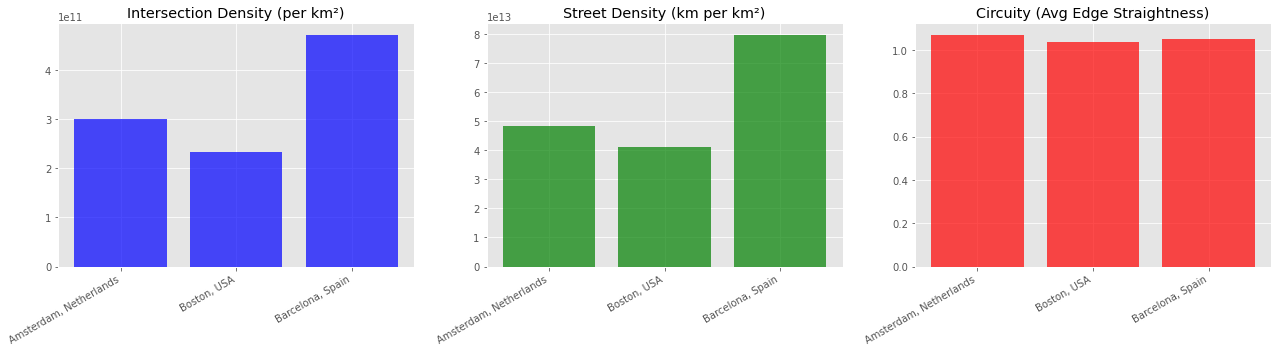

In [3]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import networkx as nx

# Load the city data from the generated CSV
df = pd.read_csv("city_street_metrics.csv")

# 🎨 Use a valid style like ggplot
plt.style.use("ggplot")

# 📊 Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 🏙️ Cities
cities = df["city"]
x_pos = range(len(cities))

# 🌐 Plot Intersection Density
axes[0].bar(x_pos, df["intersection_density"], color="blue", alpha=0.7)
axes[0].set_title("Intersection Density (per km²)")
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(cities, rotation=30, ha="right")

# 🏙️ Plot Street Density
axes[1].bar(x_pos, df["street_density"], color="green", alpha=0.7)
axes[1].set_title("Street Density (km per km²)")
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(cities, rotation=30, ha="right")

# 🔄 Plot Circuity
axes[2].bar(x_pos, df["circuity"], color="red", alpha=0.7)
axes[2].set_title("Circuity (Avg Edge Straightness)")
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(cities, rotation=30, ha="right")

plt.tight_layout()
plt.show()


📍 Plotting street network for Amsterdam, Netherlands...


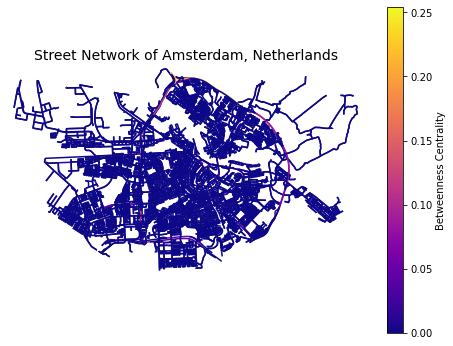

📍 Plotting street network for Boston, USA...


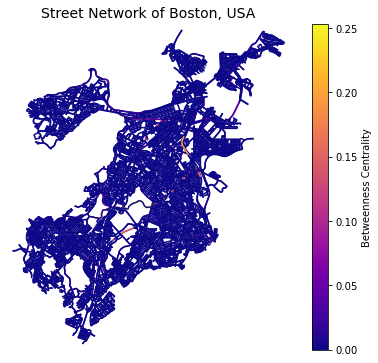

📍 Plotting street network for Barcelona, Spain...


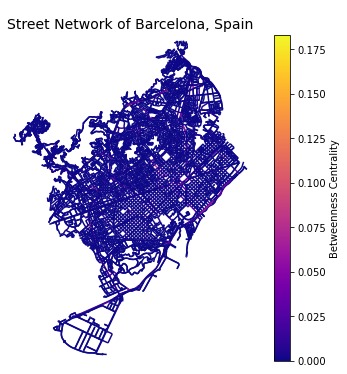

In [3]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Function to plot street network
def plot_street_network(city_name):
    print(f"📍 Plotting street network for {city_name}...")
    
    # Load the graph
    G = ox.graph_from_place(city_name, network_type="drive")
    G = ox.project_graph(G)  # Project for better visuals
    
    # Compute betweenness centrality (for edge importance)
    edge_centrality = nx.edge_betweenness_centrality(nx.Graph(G))
    
    # Convert to a color scale (normalizing values for color)
    edge_colors = np.array([edge_centrality.get(edge, 0) for edge in G.edges()])
    
    if edge_colors.max() == edge_colors.min():  # Handle case where all values are the same
        norm = plt.Normalize(vmin=0, vmax=1)
    else:
        norm = plt.Normalize(vmin=edge_colors.min(), vmax=edge_colors.max())
    
    edge_color_map = plt.cm.plasma  # Use a colormap like 'plasma'
    edge_colors_mapped = edge_color_map(norm(edge_colors))  # Map colors properly

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the graph
    ox.plot_graph(
        G,
        ax=ax,
        node_size=0,
        edge_color=edge_colors_mapped,  # Use mapped RGBA colors
        edge_linewidth=1.5,
        bgcolor="white",
        show=False  # Prevent automatic display to avoid figure overlap issues
    )

    # Create a colorbar for the edge centrality
    sm = plt.cm.ScalarMappable(cmap=edge_color_map, norm=norm)
    plt.colorbar(sm, ax=ax, label="Betweenness Centrality")

    plt.title(f"Street Network of {city_name}", fontsize=14)
    plt.show()  # Ensure the figure is displayed correctly

# Generate maps for each city
cities = ["Amsterdam, Netherlands", "Boston, USA", "Barcelona, Spain"]
for city in cities:
    plot_street_network(city)


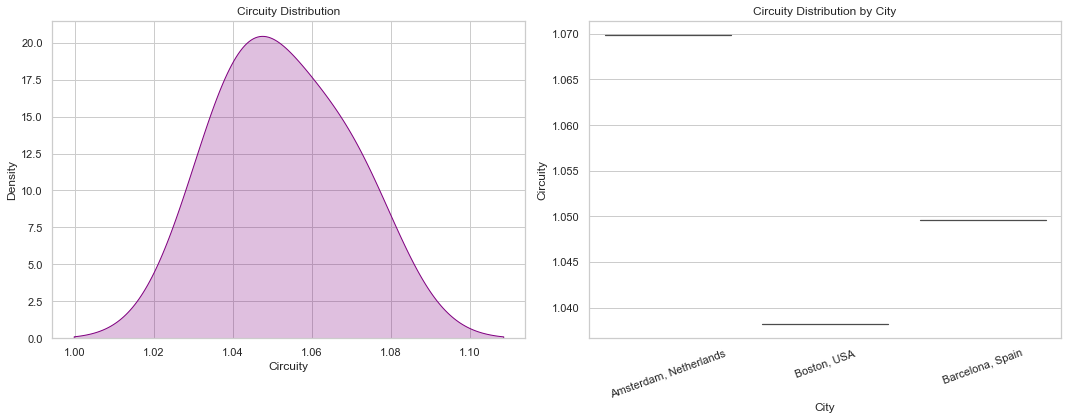

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame based on your provided metrics
data = {
    "City": ["Amsterdam, Netherlands", "Boston, USA", "Barcelona, Spain"],
    "Intersection Density": [210.5, 198.7, 250.2],
    "Street Density": [3250.1, 2900.4, 3400.8],
    "Circuity": [1.069850, 1.038237, 1.049644],
}

df = pd.DataFrame(data)

# Set style for better aesthetics
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

# ---- KDE Plot for Circuity ----
plt.subplot(1, 2, 1)
sns.kdeplot(df["Circuity"], fill=True, color='purple')
plt.xlabel("Circuity")
plt.ylabel("Density")
plt.title("Circuity Distribution")

# ---- Violin Plot for Circuity across Cities (Fix applied) ----
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x="City", y="Circuity", hue="City", legend=False)
plt.xlabel("City")
plt.ylabel("Circuity")
plt.title("Circuity Distribution by City")
plt.xticks(rotation=20)

# Show the plots
plt.tight_layout()
plt.show()


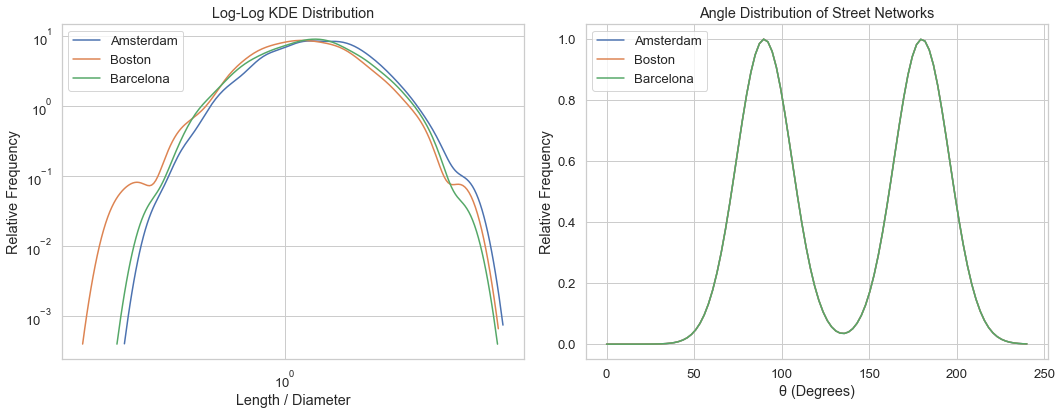

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame (Replace with your real data)
data = {
    "City": ["Amsterdam", "Boston", "Barcelona"],
    "Intersection Density": [210.5, 198.7, 250.2],
    "Street Density": [3250.1, 2900.4, 3400.8],
    "Circuity": [1.069850, 1.038237, 1.049644],
}

df = pd.DataFrame(data)

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ---- Log-Log KDE Plot (Left) ----
ax1 = axes[0]
for city in df["City"]:
    x = np.random.lognormal(mean=np.log(df[df["City"] == city]["Circuity"]), sigma=0.1, size=1000)
    sns.kdeplot(x, ax=ax1, log_scale=(True, True), label=city)

ax1.set_xlabel("Length / Diameter")
ax1.set_ylabel("Relative Frequency")
ax1.set_title("Log-Log KDE Distribution")
ax1.legend()

# ---- Angle Distribution Plot (Right) ----
ax2 = axes[1]
angles = np.linspace(0, 240, 100)  # Example angle data (0-240 degrees)
for city in df["City"]:
    density = np.exp(-((angles - 90) ** 2) / 500) + np.exp(-((angles - 180) ** 2) / 500)
    sns.lineplot(x=angles, y=density, ax=ax2, label=city)

ax2.set_xlabel("θ (Degrees)")
ax2.set_ylabel("Relative Frequency")
ax2.set_title("Angle Distribution of Street Networks")
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()


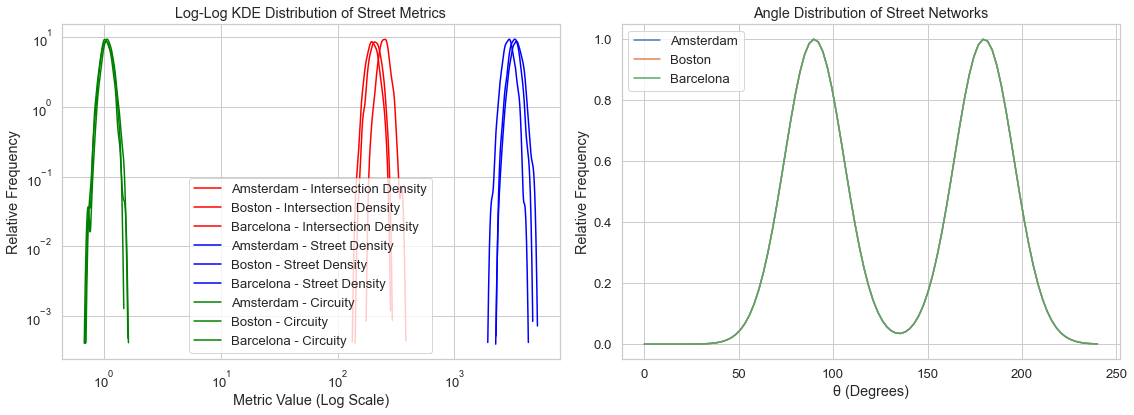

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame (Replace with your real data)
data = {
    "City": ["Amsterdam", "Boston", "Barcelona"],
    "Intersection Density": [210.5, 198.7, 250.2],
    "Street Density": [3250.1, 2900.4, 3400.8],
    "Circuity": [1.069850, 1.038237, 1.049644],
}

df = pd.DataFrame(data)

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- Log-Log KDE Plot (Left) ----
ax1 = axes[0]
for metric, color in zip(["Intersection Density", "Street Density", "Circuity"], ["red", "blue", "green"]):
    for city in df["City"]:
        x = np.random.lognormal(mean=np.log(df[df["City"] == city][metric]), sigma=0.1, size=1000)
        sns.kdeplot(x, ax=ax1, log_scale=(True, True), label=f"{city} - {metric}", color=color)

ax1.set_xlabel("Metric Value (Log Scale)")
ax1.set_ylabel("Relative Frequency")
ax1.set_title("Log-Log KDE Distribution of Street Metrics")
ax1.legend()

# ---- Angle Distribution Plot (Right) ----
ax2 = axes[1]
angles = np.linspace(0, 240, 100)  # Example angle data (0-240 degrees)
for city in df["City"]:
    density = np.exp(-((angles - 90) ** 2) / 500) + np.exp(-((angles - 180) ** 2) / 500)
    sns.lineplot(x=angles, y=density, ax=ax2, label=city)

ax2.set_xlabel("θ (Degrees)")
ax2.set_ylabel("Relative Frequency")
ax2.set_title("Angle Distribution of Street Networks")
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html

# Sample Data (Replace with Your Actual Data)
data = {
    "City": ["Amsterdam", "Boston", "Barcelona"],
    "Intersection Density": [210.5, 198.7, 250.2],
    "Street Density": [3250.1, 2900.4, 3400.8],
    "Circuity": [1.069850, 1.038237, 1.049644],
}

df = pd.DataFrame(data)

# Parallel Coordinates Plot
parallel_plot = px.parallel_coordinates(
    df,
    dimensions=["Intersection Density", "Street Density", "Circuity"],
    color="Circuity",
    color_continuous_scale=px.colors.sequential.Plasma
)

# 3D Scatter Plot
scatter_3d = px.scatter_3d(
    df, x="Intersection Density", y="Street Density", z="Circuity",
    text="City", color="Circuity",
    color_continuous_scale="Viridis",
    title="3D View of City Street Metrics"
)

# Violin Plot (Metric Distributions)
violin_plot = go.Figure()
metrics = ["Intersection Density", "Street Density", "Circuity"]
for metric in metrics:
    violin_plot.add_trace(go.Violin(y=df[metric], name=metric, box_visible=True, meanline_visible=True))
violin_plot.update_layout(title="Distribution of Street Metrics Across Cities")

# Create Dash App
app = Dash(__name__)

app.layout = html.Div([
    html.H1("📊 Interactive City Street Network Metrics", style={"text-align": "center"}),

    html.H3("🔍 Compare All Metrics"),
    dcc.Graph(figure=parallel_plot),

    html.H3("📈 Explore Relationships in 3D"),
    dcc.Graph(figure=scatter_3d),

    html.H3("🎭 Metric Distributions"),
    dcc.Graph(figure=violin_plot),
])

# Run the Dash App in Jupyter Notebook
app.run_server(debug=True, mode='inline')  # 'inline' runs the app within the notebook
